In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.cloud import bigquery
import datetime as dt
import geopandas
import random
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sktime.distances import dtw_distance
from tslearn.barycenters import dtw_barycenter_averaging
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from typing import Tuple

### 1) Import the data
- API FAOSTAT + William's package

In [8]:
### importing external libs
#os.chdir("../")
#from app.data import fetch_yield_data

- Alternatively, we will import the data manually

In [30]:
def get_df_from_bq(project_name, query):
    """
    configurar primeiro a CLI do google cloud 
    """
    client = bigquery.Client(project=project_name)
    query_job = client.query(query)
    df = query_job.result().to_dataframe()

    return df

In [31]:
query = "SELECT * FROM `windproject-393609.FAOSTAT.primary_yield`"
project_name = "windproject-393609"
df = get_df_from_bq(project_name, query)

In [23]:
df.shape

(64355, 14)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64355 entries, 0 to 64354
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain_Code       64355 non-null  object 
 1   Domain            64355 non-null  object 
 2   Area_Code__M49_   64355 non-null  Int64  
 3   Area              64355 non-null  object 
 4   Element_Code      64355 non-null  Int64  
 5   Element           64355 non-null  object 
 6   Item_Code__CPC_   64355 non-null  float64
 7   Item              64355 non-null  object 
 8   Year_Code         64355 non-null  Int64  
 9   Year              64355 non-null  Int64  
 10  Unit              64355 non-null  object 
 11  Value             28751 non-null  Int64  
 12  Flag              64355 non-null  object 
 13  Flag_Description  64355 non-null  object 
dtypes: Int64(5), float64(1), object(8)
memory usage: 7.2+ MB


### Pre-process

In [32]:
df.drop(columns = ["Domain","Domain_Code","Area_Code__M49_","Flag","Flag_Description","Element_Code","Item_Code__CPC_","Year_Code"], inplace = True)

In [34]:
len(df[df.Value.isna()])

35604

In [35]:
len(df[df.Value == None])

0

In [36]:
df["is_not_na"] = df["Value"].apply(lambda x: 1 if not pd.isna(x) else 0)

In [37]:
df["is_not_na"].value_counts()

is_not_na
0    35604
1    28751
Name: count, dtype: int64

#### Focus on only one crop (e.g. Rice yield)

In [38]:
df_rice = df[df.Item == "Rice"]

- Check completeness of the data individually in each country

In [48]:
df_country.describe()

,is_not_na
count,211.000000
mean,54.152746
std,46.969399
min,0.000000
25%,0.000000
50%,60.655738
75%,100.000000
max,100.000000


In [55]:
len(df_country[df_country.is_not_na >= 80])/len(df_country)

0.4928909952606635

In [56]:
len(df_country[df_country.is_not_na >= 90])/len(df_country)

0.47393364928909953

- __We will use only countries with at least 90% of the data__

In [57]:
df_country_new = df_country[df_country.is_not_na >= 90]

In [71]:
df_country_new[df_country_new.is_not_na < 100]

,is_not_na
Area,
Jamaica,95.081967
Rwanda,90.163934
Solomon Islands,95.081967


In [59]:
listed_complete = df_country_new.index.to_list()

In [60]:
df_rice_new = df_rice[df_rice.Area.isin(listed_complete)]

In [61]:
len(df_rice_new)

6100

- Let's take a look at the countries with missing values

In [73]:
missing = df_country_new[df_country_new.is_not_na < 100].index.to_list()

In [75]:
df_rice_new["Value"] = df_rice_new["Value"].astype(float)

<ipython-input-75-07b4f0e2f639>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rice_new["Value"] = df_rice_new["Value"].astype(float)


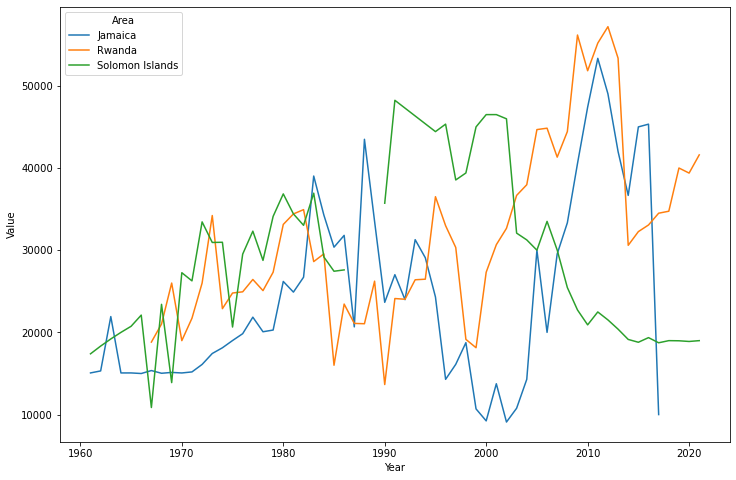

In [76]:
plt.figure(figsize=(12,8))
sns.lineplot(data = df_rice_new[df_rice_new.Area.isin(missing)], x = "Year", y = "Value", hue = "Area")
plt.show()

- Train/Validation split

In [171]:
min_year_train = df_rice_new.Year.min()
max_year_valid = df_rice_new.Year.max()
len_valid = 20
min_year_valid = max_year_valid - len_valid
max_year_train = min_year_valid - 1

In [172]:
print(f"Training from {min_year_train} to {max_year_train}")
print(f"Validation from {min_year_valid} to {max_year_valid}")

Training from 1961 to 2000
Validation from 2001 to 2021


In [173]:
df_train = df_rice_new[(df_rice_new.Year >= min_year_train) & (df_rice_new.Year <= max_year_train)]
df_valid = df_rice_new[(df_rice_new.Year >= min_year_valid) & (df_rice_new.Year <= max_year_valid)]

In [174]:
len(df_train), len(df_valid)

(4000, 2100)

- Prepare Training and Validation sequences (using an auto-regressive model with rolling stats)

In [175]:
df_train = df_train.dropna(subset = ["Value"])
df_valid = df_valid.dropna(subset = ["Value"])

In [176]:
def prepare_supervised(df, n_lags):
    
    """
    note: this prep includes the following feat eng steps:
    
    - 1) Lagged regressors of the target
    - 2) Rolling statistics over the lagged period, such as avg (over different windows), min, max and std
    
    """
    
    df_prep = df.copy()
    df_prep["target"] = df_prep["Value"]
    df_prep = df_prep[["target","Area","Year"]]
    df_prep = df_prep.sort_values(by = ["Area", "Year"])
    
    cols_lags = []
    for lag in range(1, n_lags + 1):
        cols_lags.append(f'lag_{lag}')
        df_prep[f'lag_{lag}'] = df_prep.groupby("Area")['target'].shift(lag)
    
    df_prep = df_prep.dropna(subset = cols_lags)
    
    ### calculate rolling stats over the lagged period
    
    df_prep[f'rolling_avg_{n_lags}'] = df_prep[cols_lags].mean(axis = 1)
    df_prep[f'rolling_max_{n_lags}'] = df_prep[cols_lags].max(axis = 1)
    df_prep[f'rolling_min_{n_lags}'] = df_prep[cols_lags].min(axis = 1)
    df_prep[f'rolling_std_{n_lags}'] = df_prep[cols_lags].std(axis = 1)
    df_prep[f'rolling_avg_{int(np.round(n_lags/2))}'] = df_prep[cols_lags[0:int(np.round(n_lags/2))]].mean(axis = 1)
    
    
    return df_prep

In [177]:
df_train_feats = prepare_supervised(df_train, 6)
df_valid_feats = prepare_supervised(df_valid, 6)

In [178]:
len(df_train_feats), len(df_valid_feats)

(3391, 1497)

In [179]:
df_train_feats.columns

Index(['target', 'Area', 'Year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'rolling_avg_6', 'rolling_max_6', 'rolling_min_6',
       'rolling_std_6', 'rolling_avg_3'],
      dtype='object')

In [180]:
cols_x = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'rolling_avg_6', 'rolling_max_6', 'rolling_min_6',
       'rolling_std_6', 'rolling_avg_3']

target = ['target']

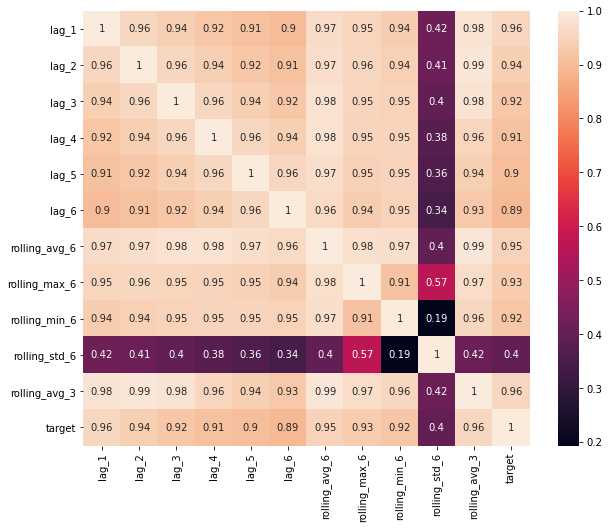

In [181]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train_feats[cols_x + target].corr(),annot=True);

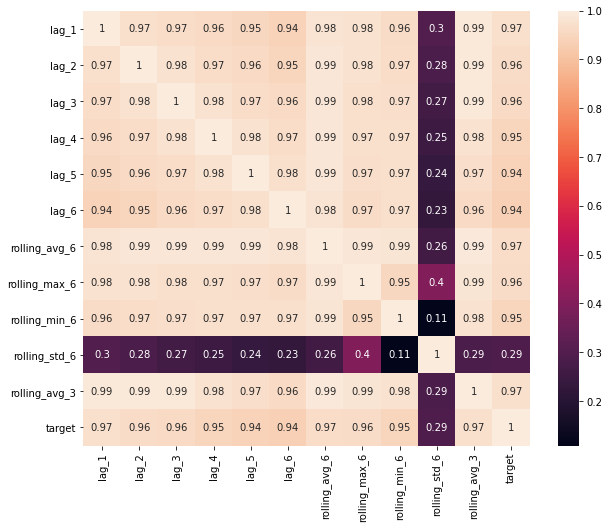

In [182]:
plt.figure(figsize=(10,8))
sns.heatmap(df_valid_feats[cols_x + target].corr(),annot=True);

- Let's train the model with these columns as a first baseline

In [351]:
hyperparameters = {  'n_estimators': 150,
                     'max_depth': 8,
                     'subsample': 0.5,
                     'min_child_weight': 1}

In [196]:
model_xgb = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )
trained_baseline = model_xgb.fit(df_train_feats[cols_x], df_train_feats[target])
train_baseline = trained_baseline.predict(df_train_feats[cols_x])
valid_baseline = trained_baseline.predict(df_valid_feats[cols_x])

In [197]:
df_train_feats["y_predict"] = train_baseline
df_valid_feats["y_predict"] = valid_baseline

- Global performance

In [198]:
def get_global_metrics(df):
    mae = mean_absolute_error(df["target"], df["y_predict"])
    mean_target = df["target"].mean()
    mae_rel = 100*mae/mean_target
    
    return [mae, mae_rel]

In [199]:
train_metrics = get_global_metrics(df_train_feats)
valid_metrics = get_global_metrics(df_valid_feats)

In [200]:
print("==== training performance ====")
print(f"MAE = {train_metrics[0]}")
print(f"MAE (%) = {train_metrics[1]}")
print("\n==== validation performance ====")
print(f"MAE = {valid_metrics[0]}")
print(f"MAE (%) = {valid_metrics[1]}")

==== training performance ====
MAE = 284.0108645817974
MAE (%) = 1.0087566361522013

==== validation performance ====
MAE = 3984.802396459586
MAE (%) = 10.149932810762094


- Country performance

In [201]:
results_country_df = []
for area in df_train_feats.Area.unique():
    m_train = get_global_metrics(df_train_feats[df_train_feats.Area == area])
    m_valid = get_global_metrics(df_valid_feats[df_valid_feats.Area == area])
    temp = pd.DataFrame(index = [0], data = {"Area":area, "Train_MAE":m_train[0], "Train_MAE_rel":m_train[1], "Valid_MAE":m_valid[0], "Valid_MAE_rel":m_valid[1] })
    results_country_df.append(temp)
results_country_df = pd.concat(results_country_df)

In [202]:
results_country_df.sort_values(by = "Valid_MAE_rel")

,Area,Train_MAE,Train_MAE_rel,Valid_MAE,Valid_MAE_rel
0,"China, mainland",224.418256,0.470631,1688.517969,2.482003
0,India,346.605239,1.576115,1204.799349,3.271416
0,Viet Nam,341.899759,1.243616,2048.018490,3.664562
0,Japan,245.153493,0.409769,2583.631771,3.742792
0,Myanmar,270.287598,1.054574,1470.226823,3.817436
...,...,...,...,...,...
0,Central African Republic,268.566981,2.295981,5961.761882,37.711666
0,Gambia,213.792868,1.460008,3211.108887,39.427846
0,Cameroon,226.934642,0.819871,5312.710254,40.684236
0,Zimbabwe,260.859655,1.727107,2308.537174,42.452473


- Visualization of tarining/validation predictions

In [203]:
def plot_predictions(df_train, df_valid, area):
    
    plt.figure(figsize=(20,6))
    sns.lineplot(data = df_train[df_train.Area == area].reset_index(), x = "Year", y = "target", label = "actuals - training")
    sns.lineplot(data = df_train[df_train.Area == area].reset_index(), x = "Year", y = "y_predict", label = "predictions - training")
    sns.lineplot(data = df_valid[df_valid.Area == area].reset_index(), x = "Year", y = "target", label = "actuals - validation")
    sns.lineplot(data = df_valid[df_valid.Area == area].reset_index(), x = "Year", y = "y_predict", label = "predictions - validation")
    plt.legend()
    plt.show()

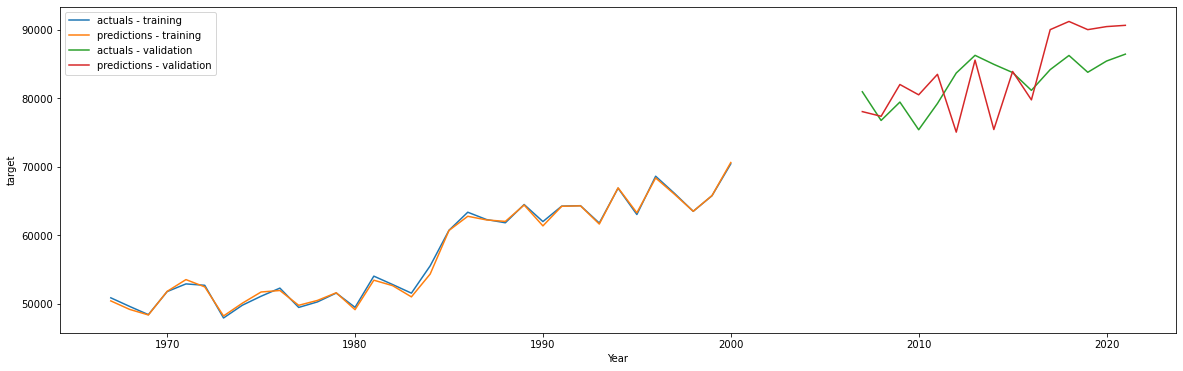

In [204]:
plot_predictions(df_train_feats, df_valid_feats, "United States of America")

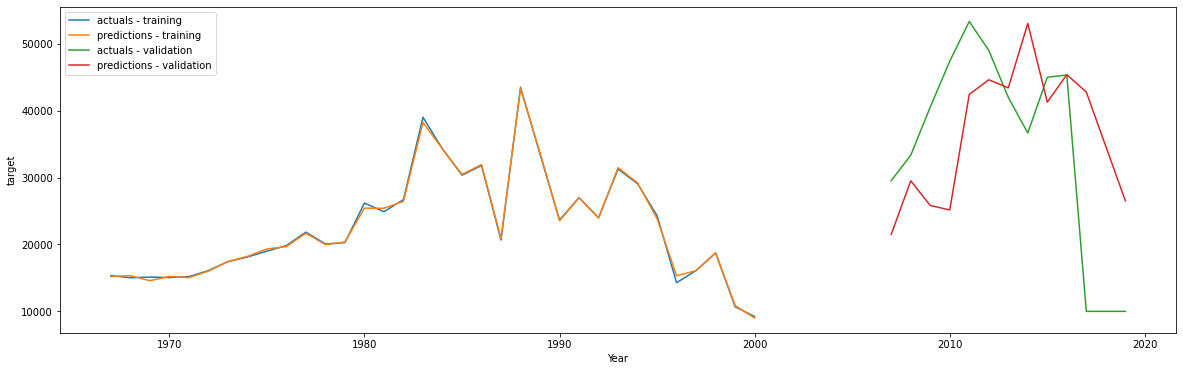

In [205]:
plot_predictions(df_train_feats, df_valid_feats, "Jamaica")

### Multistep forecasts (Direct approach)

- Data preparation

In [332]:
def prepare_supervised_multi(df, n_lags, horizon):
    
    """
    . Horizon defines the number of steps to predict:
    - target_0 would be the furthest to be predicted
    - target_[horizon - 1] would be the most recent one
    
    note: this prep includes the following feat eng steps:
    
    - 1) Lagged regressors of the target
    - 2) Rolling statistics over the lagged period, such as avg (over different windows), min, max and std
    
    """
    
    df_prep = df.copy()
    df_prep["target"] = df_prep["Value"]
    df_prep = df_prep[["target","Area","Year"]]
    df_prep = df_prep.sort_values(by = ["Area", "Year"])
    
    cols_lags = []
    cols_target = []
    for lag in range(1, n_lags + horizon):
        if horizon > 1:
            df_prep.rename(columns = {"target":"target_0"}, inplace = True)
            cols_target.append("target_0")
            if lag < horizon:
                cols_target.append(f'target_{lag}')
                df_prep[f'target_{lag}'] = df_prep.groupby("Area")['target_0'].shift(lag)
            else:
                lag2 = lag - horizon + 1
                cols_lags.append(f'lag_{lag2}')
                df_prep[f'lag_{lag2}'] = df_prep.groupby("Area")[f'target_{(horizon-1)}'].shift(lag2)
                
        else:
            cols_lags.append(f'lag_{lag}')
            df_prep[f'lag_{lag}'] = df_prep.groupby("Area")['target'].shift(lag)
    
    df_prep = df_prep.dropna(subset = cols_lags)
    
    ### calculate rolling stats over the lagged period
    
    df_prep[f'rolling_avg_{n_lags}'] = df_prep[cols_lags].mean(axis = 1)
    df_prep[f'rolling_max_{n_lags}'] = df_prep[cols_lags].max(axis = 1)
    df_prep[f'rolling_min_{n_lags}'] = df_prep[cols_lags].min(axis = 1)
    df_prep[f'rolling_std_{n_lags}'] = df_prep[cols_lags].std(axis = 1)
    df_prep[f'rolling_avg_{int(np.round(n_lags/2))}'] = df_prep[cols_lags[0:int(np.round(n_lags/2))]].mean(axis = 1)
    
    cols_x = cols_lags + [f'rolling_avg_{n_lags}',
                          f'rolling_max_{n_lags}',
                          f'rolling_min_{n_lags}',
                          f'rolling_std_{n_lags}',
                          f'rolling_avg_{int(np.round(n_lags/2))}'
                         ]
    cols_target = list(set(cols_target))
    cols_target.sort()
    
    return df_prep, cols_x, cols_target

In [352]:
df_train_multi, cols_x, cols_target = prepare_supervised_multi(df_train, 6, 3)
df_valid_multi, cols_x, cols_target = prepare_supervised_multi(df_valid, 6, 3)

In [354]:
cols_x

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'rolling_avg_6',
 'rolling_max_6',
 'rolling_min_6',
 'rolling_std_6',
 'rolling_avg_3']

In [355]:
cols_target

['target_0', 'target_1', 'target_2']

In [356]:
model_xgb_multi = xgb.XGBRegressor(
                                    n_estimators=hyperparameters["n_estimators"],
                                    max_depth=hyperparameters["max_depth"],
                                    subsample=hyperparameters["subsample"],
                                    min_child_weight=hyperparameters["min_child_weight"],
                                    objective="reg:squarederror",
                                    tree_method="hist"
                                    )

model_baseline_multi = MultiOutputRegressor(model_xgb_multi).fit(df_train_multi[cols_x], df_train_multi[cols_target])
train_baseline_multi = model_baseline_multi.predict(df_train_multi[cols_x])
valid_baseline_multi = model_baseline_multi.predict(df_valid_multi[cols_x])

In [358]:
df_train_multi[['y_predict_0', 'y_predict_1', 'y_predict_2']] = train_baseline_multi
df_valid_multi[['y_predict_0', 'y_predict_1', 'y_predict_2']] = valid_baseline_multi

In [359]:
def get_global_metrics_multi(df, horizon):
    
    metrics = []
    for h in range(0, horizon):
        mae = mean_absolute_error(df[f"target_{h}"], df[f"y_predict_{h}"])
        mean_target = df[f"target_{h}"].mean()
        mae_rel = 100*mae/mean_target
        metrics.append([mae, mae_rel])
    
    df_metrics = pd.DataFrame(metrics).T.rename(columns = {col: f"Year + {horizon - col}" for col in range(0, horizon)})
    
    df_metrics.rename(index = {0: "MAE",1:"MAE (%)"}, inplace = True)
    
    return df_metrics

In [360]:
df_metrics_multi_train = get_global_metrics_multi(df_train_multi, 3)
df_metrics_multi_valid = get_global_metrics_multi(df_valid_multi, 3)

In [361]:
df_metrics_multi_train

,Year + 3,Year + 2,Year + 1
MAE,301.017036,262.863121,262.179654
MAE (%),1.057363,0.933700,0.941840


In [362]:
df_metrics_multi_valid

,Year + 3,Year + 2,Year + 1
MAE,5785.598908,5164.505786,4378.621253
MAE (%),14.577068,13.107172,11.227076
